# PET deconvolution data setup notebook

In this notebook we'll simulate some 3D FDG brain PET acquisitions. \
1. Create FDG, uMap, T1 images of the brain as Numpy arrays - create SIRF `ImageData` objects using these
2. Create a `BlurringOperator` using CIL and an `AcquisitionModel` using SIRF. Use CIL's `CompositionOperator` to create a blurred forward model
3. Create simulated PET data using this blurred forward model
4. Using SIRF's `OSMAPOSLReconstructor` class, produce an OSEM-reoncstructed image that will be both blurred and noisy when compared to the ground truth image
5. Simulate a point source and use the blurred forward model to simulate the result of taking a point source measurement with our PET scanner

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import sirf.STIR as pet
import brainweb

from cil.utilities.display import show2D
from cil.optimisation.operators import  BlurringOperator, CompositionOperator

msg = pet.MessageRedirector() # suppress STIR messages

In [2]:
noise_seed = 5
noise_level = 1
bw_seed = 1337

subject_04.bin.gz: 0.00B [00:00, ?B/s]

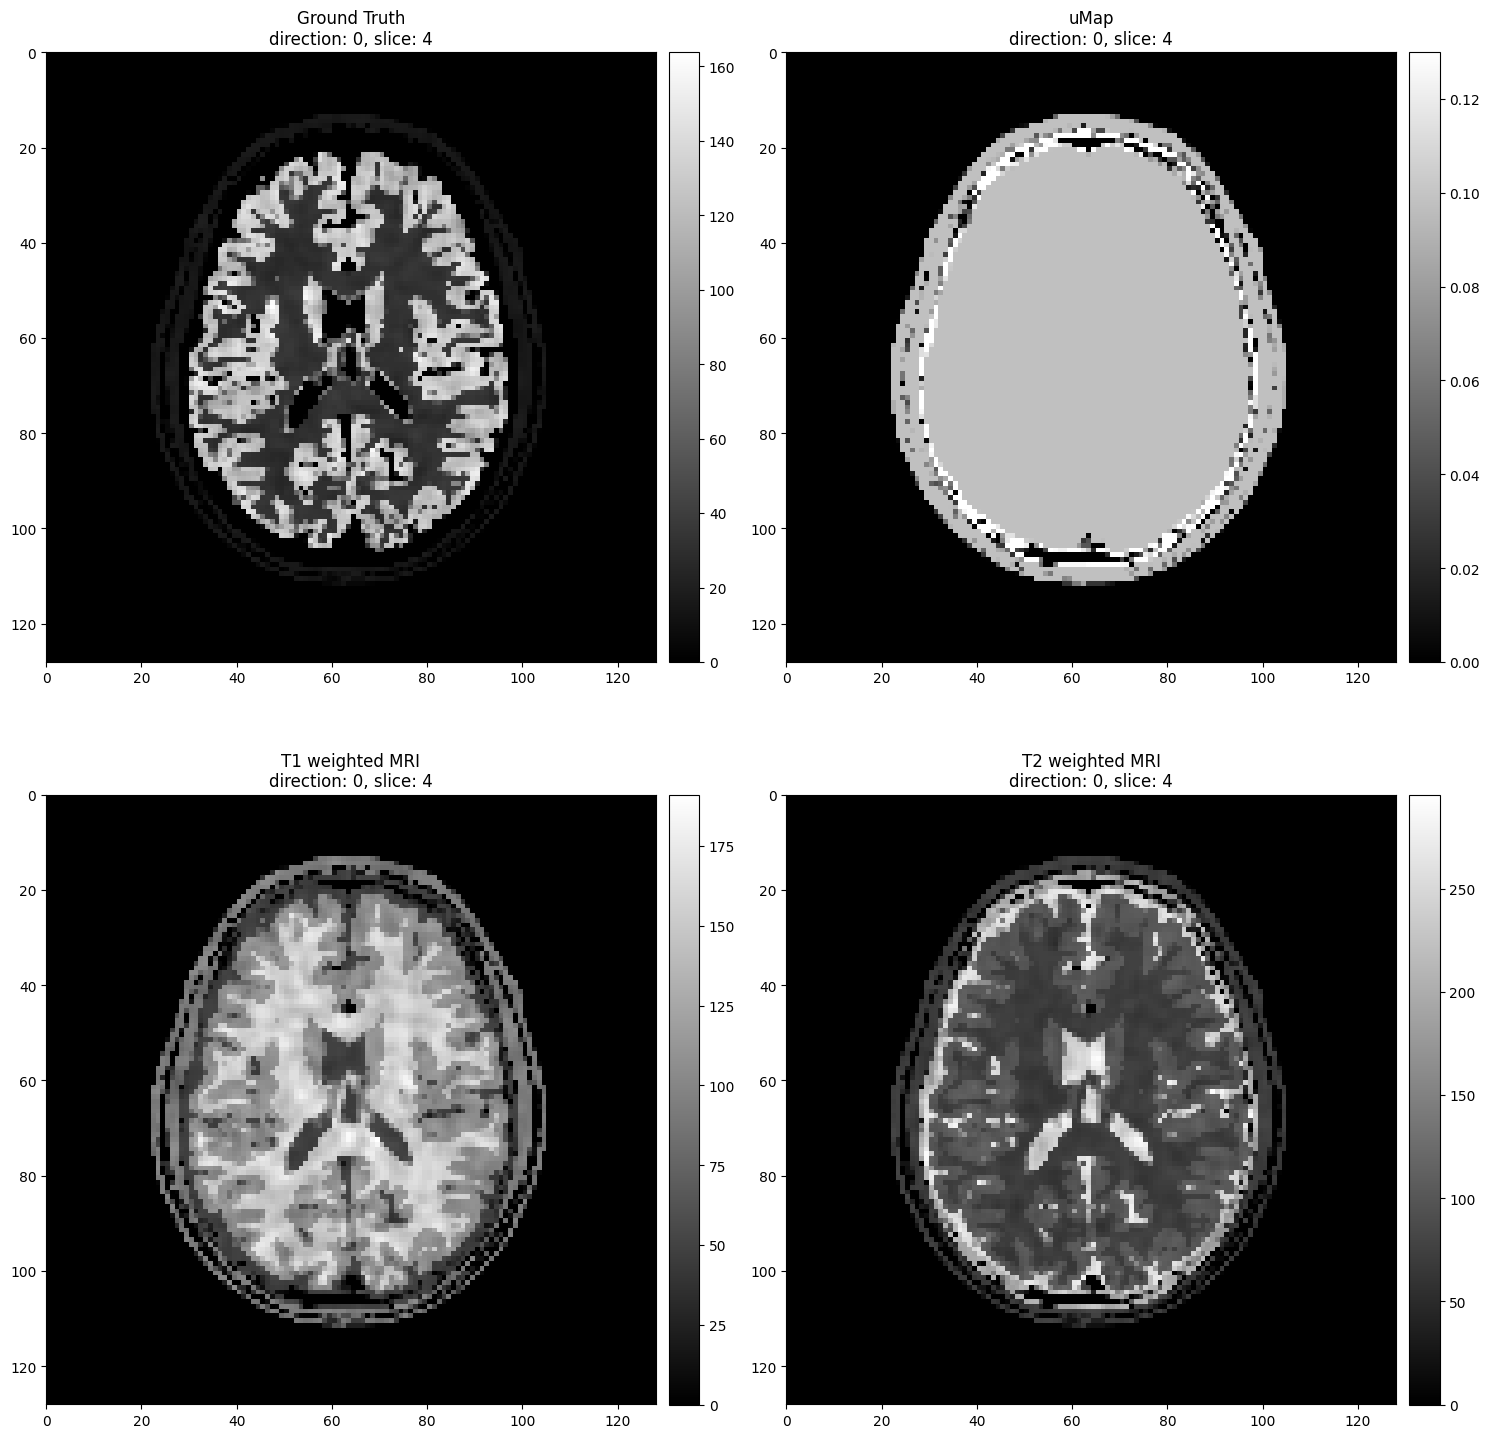

In [3]:
fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, "data")
data = brainweb.load_file(os.path.join("data", fname))

# Ensure that we get the same data every time this cell is run
brainweb.seed(bw_seed)

vol = brainweb.get_mmr_fromfile(os.path.join("data", fname),
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1)

# We'll extract the ground truth FDG PET, T1 MRI and T2 MRI images as well as the attenuation image (uMap)
arr_dict = {'PET': vol['PET'], 'T1': vol['T1'], 'T2': vol['T2'], 'uMap': vol['uMap']}

# desired shape of the images - note that changing these values requires updating the template sinogram header file
crop_dim = (8,128,128)

for key, image in arr_dict.items():
    shape = image.shape
    z_start, y_start, x_start = (shape[0] - crop_dim[0])//2, (shape[1] - crop_dim[1])//2, (shape[2] - crop_dim[2])//2
    z_end, y_end, x_end = z_start + crop_dim[0], y_start + crop_dim[1], x_start + crop_dim[2]
    
    arr_dict[key] = image[z_start:z_end, y_start:y_end, x_start:x_end]

show2D([arr_dict['PET'], arr_dict['uMap'], arr_dict['T1'], arr_dict['T2']], title = ['Ground Truth', 'uMap', 'T1 weighted MRI', 'T2 weighted MRI'], origin = 'upper', num_cols = 2)

In [4]:
# Create a dictionary to store the SIRF ImageData objects and then initialise them
image_dict = {}
vsize = (2.03125, 2.08626, 2.08626) # voxel sizes in mm
for key, image in arr_dict.items():
    image_dict[key] = pet.ImageData()
    image_dict[key].initialise(dim = crop_dim, vsize = vsize)
    image_dict[key].fill(image)
    image_dict[key].write(os.path.join('data',f'{key}_b{bw_seed}.hv'))

In [5]:
def fwhm_to_sigma(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def psf(n, fwhm, voxel_size=(1, 1, 1)):
    """ Creates a 3D point spread function (PSF) with specified sizes `n`, FWHM values `fwhm`, and voxel sizes `voxel_size` """

    sigma_voxels = [fwhm_to_sigma(fwhm[i]) / voxel_size[i] for i in range(3)]
    
    # Create Gaussian distributions for each dimension
    axes = [np.linspace(-(n - 1) / 2., (n - 1) / 2., n) for i in range(3)]
    gauss = [np.exp(-0.5 * np.square(ax) / np.square(sigma_voxels[i])) for i, ax in enumerate(axes)]

    # Create 3D Gaussian kernel
    kernel_3d = np.outer(gauss[0], gauss[1]).reshape(n, n, 1) * gauss[2].reshape(1, 1, n)
    
    # Normalize the kernel to ensure its sum equals one
    return kernel_3d / np.sum(kernel_3d)

PSF=psf(15, fwhm=(7,7,7), voxel_size=vsize)
convolve=BlurringOperator(PSF, image_dict['PET'])

In [6]:
def make_acquisition_model(template_sinogram, template_image, atten_image):

    # We'll start by initialising the acquisition model object
    acq_model = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_model.set_num_tangential_LORs(10) 

    # In order to create LOR attenuation coefficients, we need to project the attenuation image into sinogram space
    acq_asm = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_asm.set_num_tangential_LORs(10)
    acq_model.set_acquisition_sensitivity(pet.AcquisitionSensitivityModel(atten_image, acq_asm))

    # And finally, we can set up the acquisition model
    acq_model.set_up(template_sinogram,template_image)

    return acq_model

def add_poission_noise(acquistion_data, noise_level=10, seed=10):
    """
    Adds poisson noise to acquisition data
    """
    np.random.seed(seed)
    noisy_data = np.random.poisson(acquistion_data.as_array()/noise_level)*noise_level
    return acquistion_data.clone().fill(noisy_data)




Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added

Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added


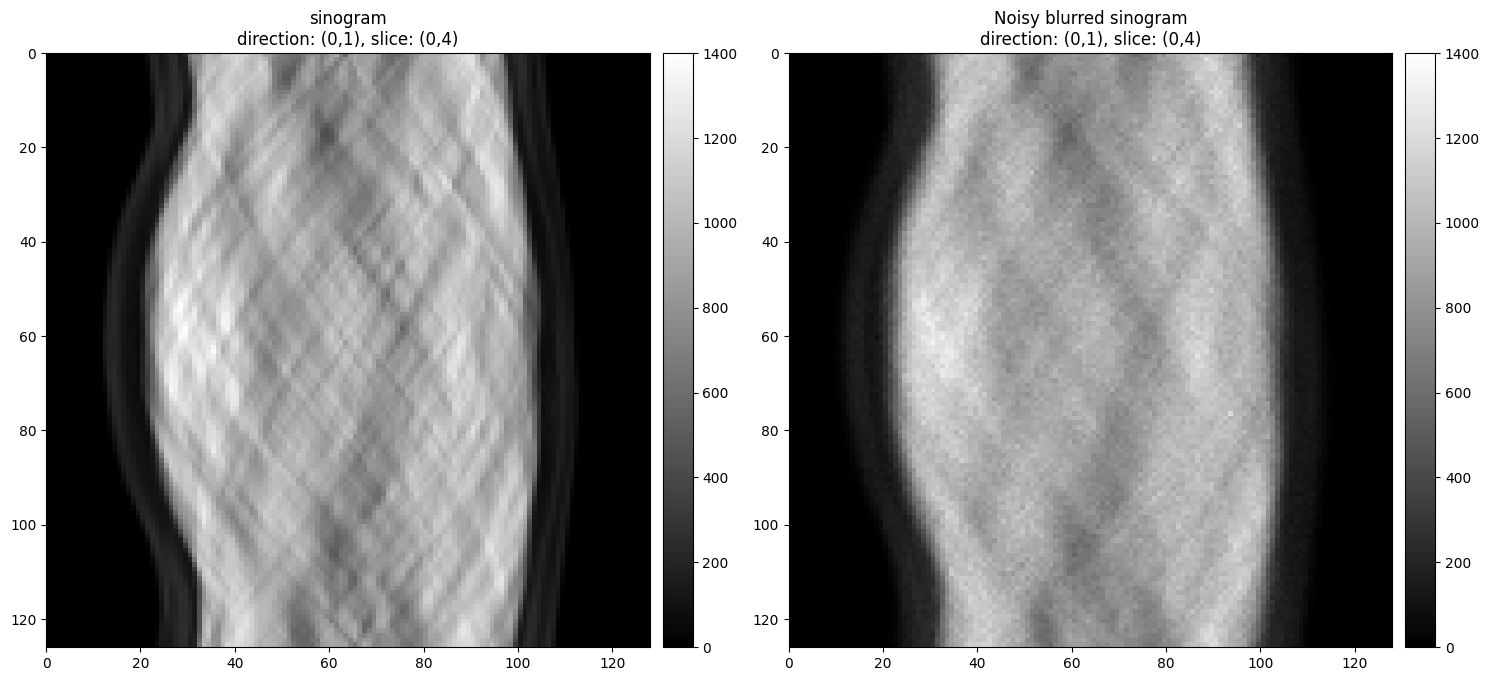

In [7]:
acq_model = make_acquisition_model(pet.AcquisitionData(os.path.join('data', 'template_sinogram.hs')), image_dict['PET'], image_dict['uMap'])

# We'll now create a noiseless sinogram and add poisson noise to it
sinogram = acq_model.direct(image_dict['PET'])

# And now we'll model the forward operator including the point spread function
blurred_acq_model=CompositionOperator(acq_model, convolve)
blurred_sinogram=blurred_acq_model.direct(image_dict['PET'])
blurred_noisy_sinogram=add_poission_noise(blurred_sinogram, noise_level=noise_level, seed=noise_seed)

show2D([sinogram, blurred_noisy_sinogram], title = ['sinogram', 'Noisy blurred sinogram'], origin = 'upper', num_cols = 2, fix_range=[(0,1400), (0,1400)])

In [8]:
sinogram.write(f'data/bw_sinogram_b{bw_seed}.hs')
blurred_noisy_sinogram.write(f'data/bw_blurred_noisy_sinogram_b_{bw_seed}_n{noise_seed}.hs')

In [9]:
# remove all files left over that should have been delted
# these start with tmp_ and end with .hs or .s
for file in os.listdir('.'):
    if file.startswith('tmp_') and (file.endswith('.hs') or file.endswith('.s')):
        os.remove(f'{file}')


Going ahead anyway.
Iteration: 49, Objective: -214352176.0


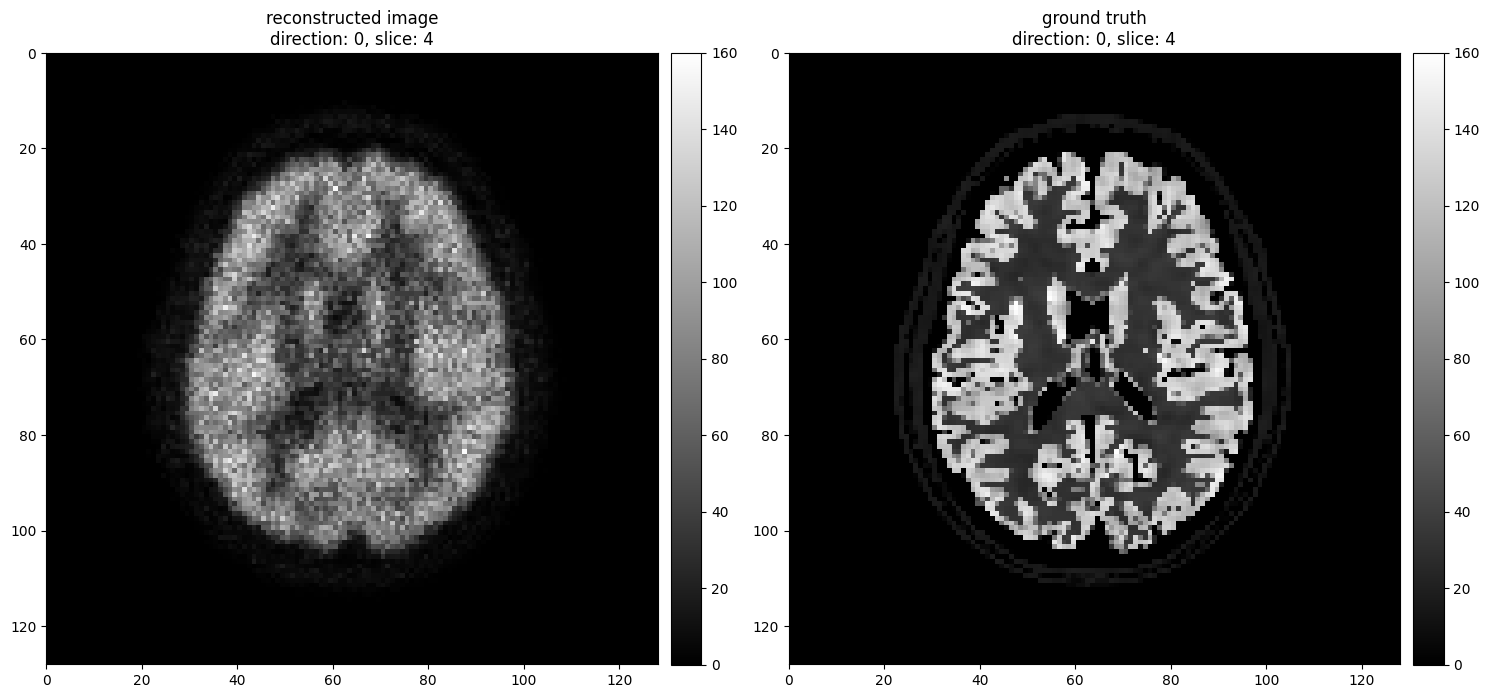

Text(0, 0.5, 'Objective Function Value')

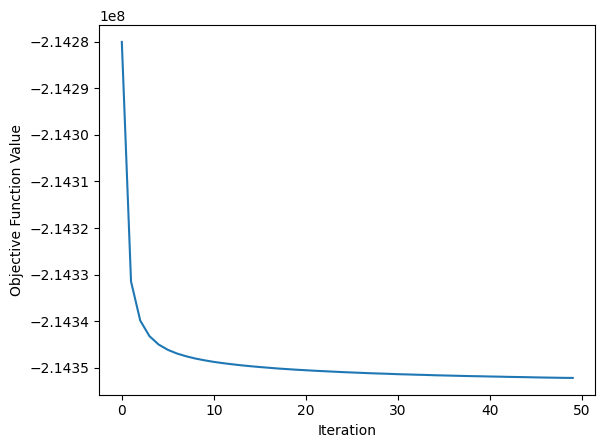

In [10]:
objective_function = pet.make_Poisson_loglikelihood(blurred_noisy_sinogram, acq_model=acq_model)
objective_function.set_num_subsets(8)
reconstructor = pet.OSMAPOSLReconstructor()
reconstructor.set_num_subiterations(8)
reconstructor.set_objective_function(objective_function)
reconstructor.set_up(image_dict['PET'])

# create a processor to truncate the image to the cylinder
# This prevents edge effects from ruining the reconstruction
cyl = pet.TruncateToCylinderProcessor()
cyl.set_strictly_less_than_radius(True)

current_estimate = image_dict['PET'].get_uniform_copy(1)
objective_list = []
full_iterations = 50

for i in range(full_iterations):
    reconstructor.reconstruct(current_estimate)
    objective_list.append(-objective_function(current_estimate))
    print(f"Iteration: {i}, Objective: {objective_list[-1]}", end = '\r')
    # remove any weird stuff from edge effects
    cyl.apply(current_estimate)

current_estimate.write(f'data/OSEM_b{bw_seed}_n{noise_seed}.hv')

show2D([current_estimate, image_dict['PET']], 
       title = ['reconstructed image', 'ground truth'], 
       origin = 'upper', num_cols = 2, fix_range=[(0,160), (0,160)])

plt.plot(objective_list)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')


Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added

Going ahead anyway.
Iteration: 24, Objective: -5257.11474609375


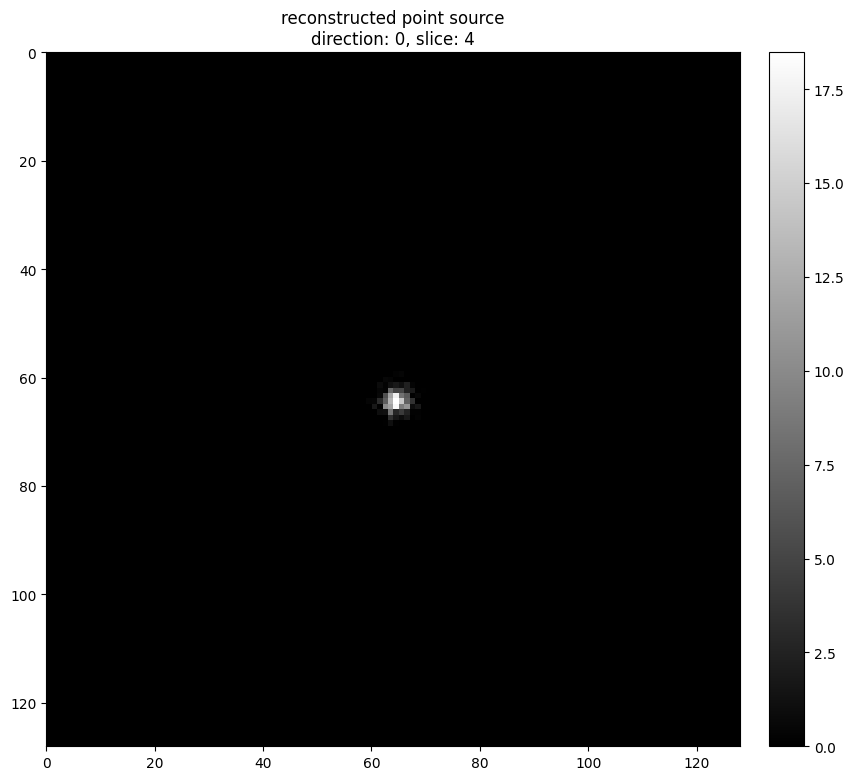

Text(0, 0.5, 'Objective Function Value')

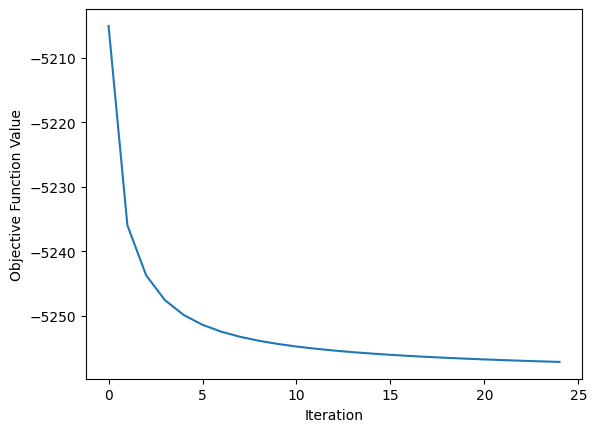

In [11]:
point_source = image_dict['PET'].get_uniform_copy(0)
point_source_arr = point_source.as_array()

point_source_arr[point_source_arr.shape[0]//2, point_source_arr.shape[1]//2, point_source_arr.shape[2]//2] = 1000
point_source.fill(point_source_arr)

point_source_sinogram = blurred_acq_model.direct(point_source)
point_source_sinogram = add_poission_noise(point_source_sinogram, noise_level=noise_level, seed=noise_seed)

objective_function = pet.make_Poisson_loglikelihood(point_source_sinogram, acq_model=acq_model)
objective_function.set_num_subsets(8)
reconstructor = pet.OSMAPOSLReconstructor()
reconstructor.set_num_subiterations(8)
reconstructor.set_objective_function(objective_function)
reconstructor.set_up(image_dict['PET'])

current_ps_estimate = image_dict['PET'].get_uniform_copy(1)
objective_list = []
full_iterations = 25

for i in range(full_iterations):
    reconstructor.reconstruct(current_ps_estimate)
    objective_list.append(-objective_function(current_ps_estimate))
    print(f"Iteration: {i}, Objective: {objective_list[-1]}", end = '\r')
    # remove any weird stuff from edge effects
    cyl.apply(current_ps_estimate)

current_ps_estimate.write(os.path.join('data', f'OSEM_psf_n{noise_seed}.hv'))

show2D(reconstructor.get_current_estimate(), 
       title = 'reconstructed point source', 
       origin = 'upper', num_cols = 1)

plt.plot(objective_list)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')


## References

### Brainweb
C.A. Cocosco, V. Kollokian, R.K.-S. Kwan, A.C. Evans : "BrainWeb: Online Interface to a 3D MRI Simulated Brain Database"
NeuroImage, vol.5, no.4, part 2/4, S425, 1997 -- Proceedings of 3-rd International Conference on Functional Mapping of the Human Brain, Copenhagen, May 1997.
